In [1]:
!pip install numpy==1.23.5
!pip install --upgrade mxnet==1.6.0
!pip install gluonts

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from gluonts.torch import DeepAREstimator
from gluonts.mx.trainer import Trainer
import numpy as np

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [3]:
cluster_number = 3
features = pd.read_parquet("/content/features.parquet")
features = features.sort_values(["pdv_codigo", "codigo_barras_sku", "fecha_comercial"]).reset_index(drop=True)
features = features[features["cluster"] == cluster_number]
sku = 7894900027013


filtered = features[
    (features["codigo_barras_sku"] == sku)
].copy()
filtered

,pdv_codigo,fecha_comercial,codigo_barras_sku,nombre_sku,imp_vta,cant_vta,stock,year,month,day,day_of_week,is_weekend,quarter,week_of_year,day_of_year,is_month_start,is_month_end,is_first_week,is_last_week,cluster
78393,1,2022-12-01,7894900027013,REFRIG COCA COLA PET 2L,1212.12,296000.0,NaN,2022,12,1,3,0,4,48,335,1,0,1,0,3
78394,1,2022-12-02,7894900027013,REFRIG COCA COLA PET 2L,2104.83,514000.0,NaN,2022,12,2,4,0,4,48,336,0,0,1,0,3
78395,1,2022-12-03,7894900027013,REFRIG COCA COLA PET 2L,1925.59,482000.0,NaN,2022,12,3,5,1,4,48,337,0,0,1,0,3
78396,1,2022-12-04,7894900027013,REFRIG COCA COLA PET 2L,1677.90,420000.0,NaN,2022,12,4,6,1,4,48,338,0,0,1,0,3
78397,1,2022-12-05,7894900027013,REFRIG COCA COLA PET 2L,1030.71,258000.0,NaN,2022,12,5,0,0,4,49,339,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3881974,30,2024-12-05,7894900027013,REFRIG COCA COLA PET 2L,1045.25,226000.0,1681.0,2024,12,5,3,0,4,49,340,0,0,1,0,3
3881975,30,2024-12-06,7894900027013,REFRIG COCA COLA PET 2L,1304.25,282000.0,2059.0,2024,12,6,4,0,4,49,341,0,0,1,0,3
3881976,30,2024-12-07,7894900027013,REFRIG COCA COLA PET 2L,1860.93,414000.0,1918.0,2024,12,7,5,1,4,49,342,0,0,1,0,3
3881977,30,2024-12-08,7894900027013,REFRIG COCA COLA PET 2L,1350.50,292000.0,1565.0,2024,12,8,6,1,4,49,343,0,0,0,0,3


In [4]:
filtered.columns


Index(['pdv_codigo', 'fecha_comercial', 'codigo_barras_sku', 'nombre_sku',
       'imp_vta', 'cant_vta', 'stock', 'year', 'month', 'day', 'day_of_week',
       'is_weekend', 'quarter', 'week_of_year', 'day_of_year',
       'is_month_start', 'is_month_end', 'is_first_week', 'is_last_week',
       'cluster'],
      dtype='object')

In [5]:
df = filtered.pivot(
    index="fecha_comercial",
    columns="pdv_codigo",
    values="cant_vta"
)


df.columns = [f"pdv_codigo_{col}" for col in df.columns]
df

,pdv_codigo_1,pdv_codigo_2,pdv_codigo_3,pdv_codigo_4,pdv_codigo_5,pdv_codigo_6,pdv_codigo_7,pdv_codigo_8,pdv_codigo_9,pdv_codigo_10,...,pdv_codigo_21,pdv_codigo_22,pdv_codigo_23,pdv_codigo_24,pdv_codigo_25,pdv_codigo_26,pdv_codigo_27,pdv_codigo_28,pdv_codigo_29,pdv_codigo_30
fecha_comercial,,,,,,,,,,,,,,,,,,,,,
2022-12-01,296000.0,348000.0,490000.0,300000.0,156000.0,424000.0,170000.0,268000.0,170000.0,218000.0,...,284000.0,134000.0,206000.0,704000.0,116000.0,350000.0,336000.0,342000.0,360000.0,384000.0
2022-12-02,514000.0,566000.0,622000.0,322000.0,220000.0,724000.0,228000.0,378000.0,234000.0,384000.0,...,324000.0,238000.0,260000.0,972000.0,188000.0,632000.0,490000.0,578000.0,426000.0,424000.0
2022-12-03,482000.0,632000.0,654000.0,314000.0,214000.0,844000.0,162000.0,390000.0,276000.0,414000.0,...,426000.0,204000.0,204000.0,924000.0,198000.0,606000.0,682000.0,570000.0,424000.0,484000.0
2022-12-04,420000.0,436000.0,420000.0,250000.0,164000.0,726000.0,52000.0,280000.0,264000.0,398000.0,...,366000.0,190000.0,184000.0,730000.0,312000.0,482000.0,560000.0,508000.0,300000.0,310000.0
2022-12-05,258000.0,362000.0,342000.0,280000.0,142000.0,452000.0,56000.0,252000.0,164000.0,308000.0,...,328000.0,104000.0,86000.0,530000.0,130000.0,364000.0,376000.0,284000.0,294000.0,282000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-06,182000.0,360000.0,532000.0,200000.0,272000.0,434000.0,74000.0,174000.0,120000.0,156000.0,...,246000.0,226000.0,150000.0,536000.0,212000.0,300000.0,438000.0,260000.0,246000.0,282000.0
2024-12-07,420000.0,554000.0,572000.0,248000.0,244000.0,602000.0,188000.0,230000.0,236000.0,322000.0,...,302000.0,258000.0,188000.0,786000.0,280000.0,352000.0,554000.0,490000.0,356000.0,414000.0
2024-12-08,430000.0,374000.0,344000.0,146000.0,232000.0,564000.0,126000.0,216000.0,220000.0,304000.0,...,354000.0,224000.0,184000.0,534000.0,212000.0,294000.0,620000.0,408000.0,336000.0,292000.0


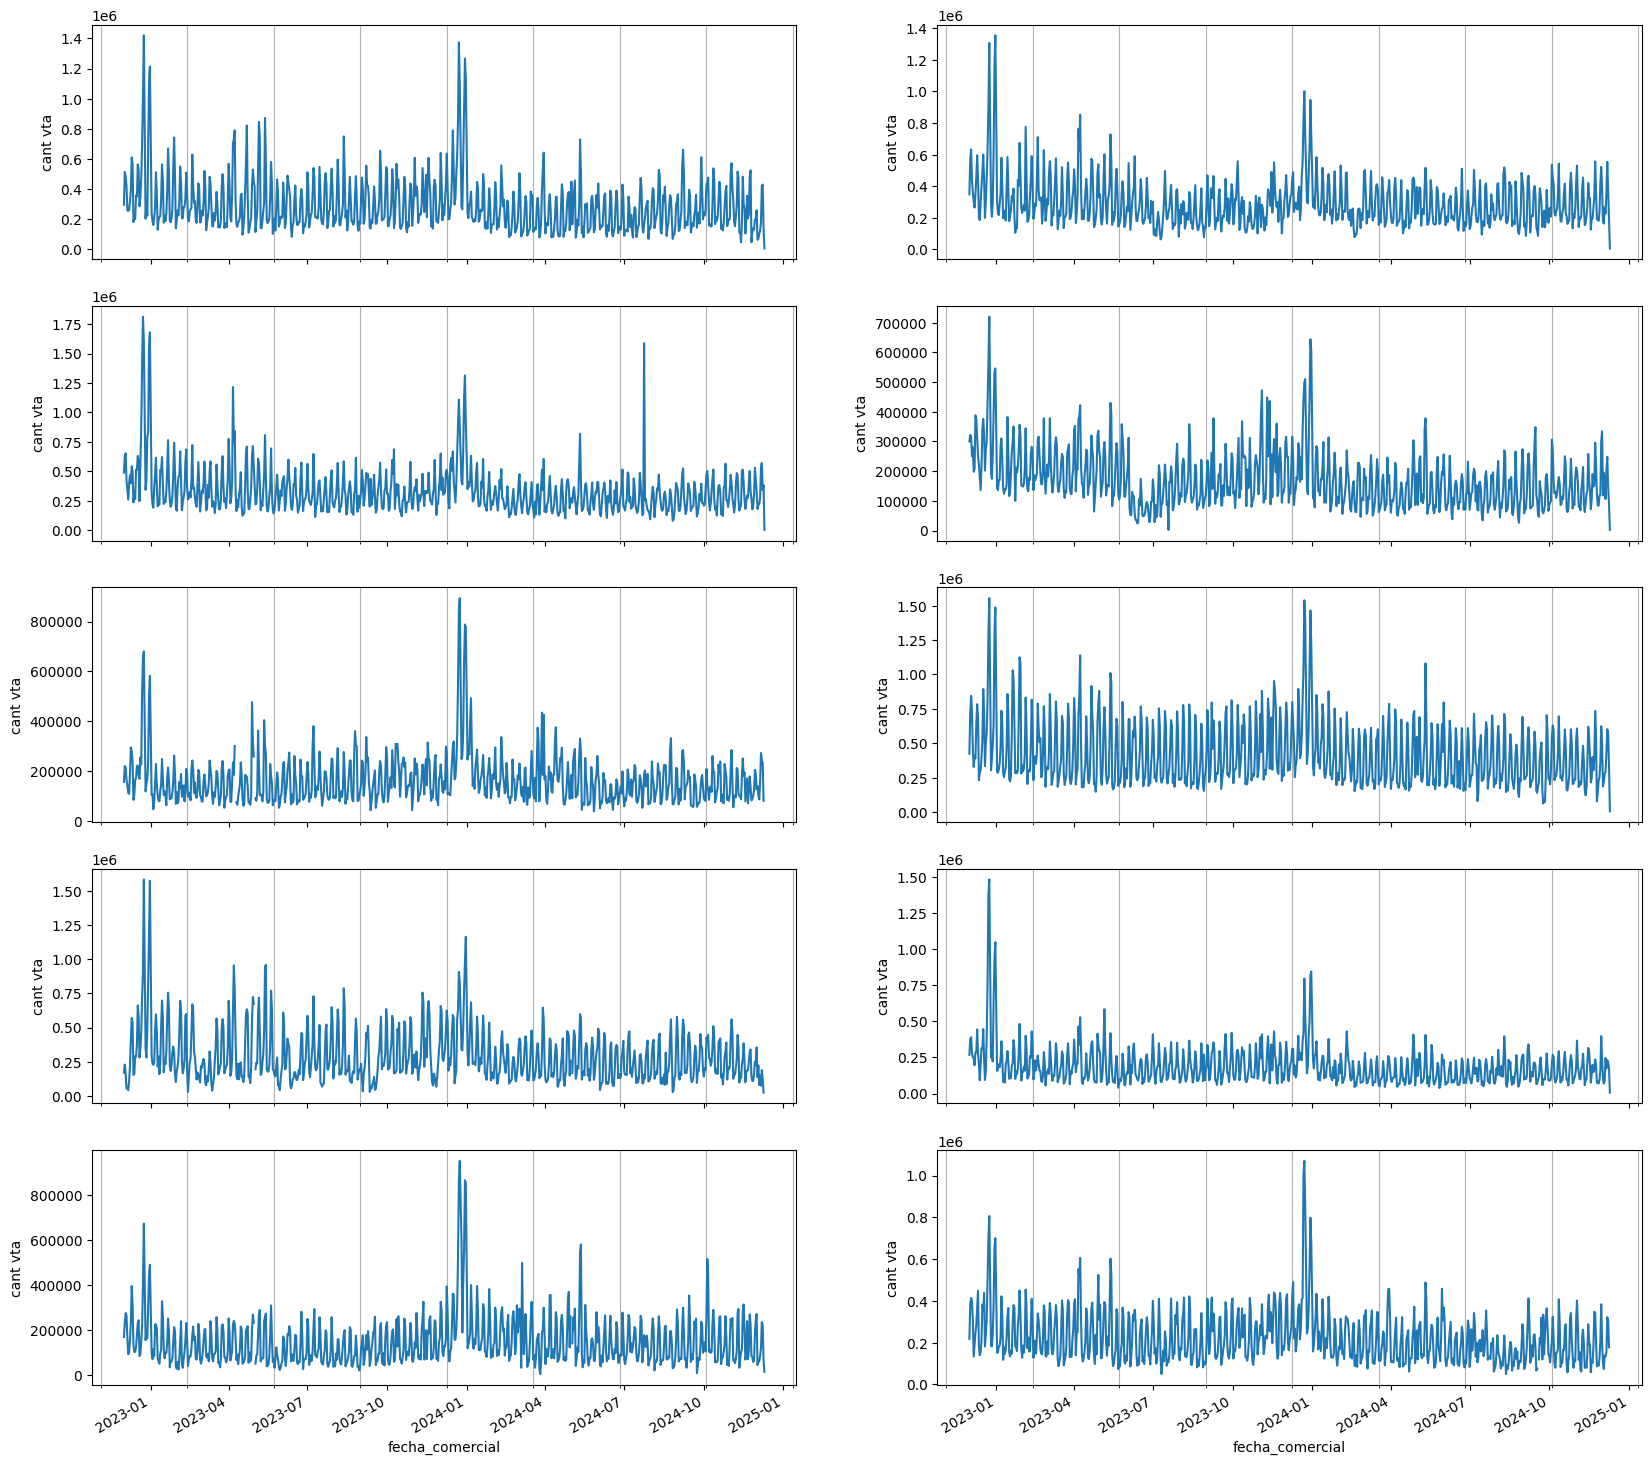

In [6]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    df[df.columns[i]].loc["2014-12-01":"2024-12-10"].plot(ax=axx[i])
    axx[i].set_xlabel("fecha_comercial")
    axx[i].set_ylabel("cant vta")
    axx[i].grid(which='minor', axis='x')

In [7]:
df_input=df.reset_index(drop=True).T.reset_index()
df_input

,index,0,1,2,3,4,5,6,7,8,...,727,728,729,730,731,732,733,734,735,736
0,pdv_codigo_1,296000.0,514000.0,482000.0,420000.0,258000.0,256000.0,262000.0,318000.0,392000.0,...,260000.0,64000.0,70000.0,106000.0,122000.0,182000.0,420000.0,430000.0,142000.0,6000.0
1,pdv_codigo_2,348000.0,566000.0,632000.0,436000.0,362000.0,302000.0,264000.0,352000.0,456000.0,...,392000.0,176000.0,162000.0,266000.0,226000.0,360000.0,554000.0,374000.0,202000.0,4000.0
2,pdv_codigo_3,490000.0,622000.0,654000.0,420000.0,342000.0,262000.0,402000.0,468000.0,400000.0,...,330000.0,182000.0,216000.0,224000.0,276000.0,532000.0,572000.0,344000.0,384000.0,4000.0
3,pdv_codigo_4,300000.0,322000.0,314000.0,250000.0,280000.0,198000.0,208000.0,388000.0,376000.0,...,334000.0,118000.0,194000.0,166000.0,106000.0,200000.0,248000.0,146000.0,88000.0,2000.0
4,pdv_codigo_5,156000.0,220000.0,214000.0,164000.0,142000.0,112000.0,108000.0,188000.0,294000.0,...,126000.0,140000.0,102000.0,86000.0,154000.0,272000.0,244000.0,232000.0,80000.0,NaN
5,pdv_codigo_6,424000.0,724000.0,844000.0,726000.0,452000.0,328000.0,404000.0,390000.0,642000.0,...,500000.0,186000.0,218000.0,282000.0,290000.0,434000.0,602000.0,564000.0,340000.0,6000.0
6,pdv_codigo_7,170000.0,228000.0,162000.0,52000.0,56000.0,40000.0,108000.0,220000.0,412000.0,...,354000.0,136000.0,222000.0,78000.0,148000.0,74000.0,188000.0,126000.0,22000.0,NaN
7,pdv_codigo_8,268000.0,378000.0,390000.0,280000.0,252000.0,244000.0,196000.0,286000.0,286000.0,...,236000.0,100000.0,68000.0,92000.0,246000.0,174000.0,230000.0,216000.0,174000.0,6000.0
8,pdv_codigo_9,170000.0,234000.0,276000.0,264000.0,164000.0,94000.0,104000.0,156000.0,234000.0,...,272000.0,46000.0,62000.0,62000.0,86000.0,120000.0,236000.0,220000.0,70000.0,16000.0
9,pdv_codigo_10,218000.0,384000.0,414000.0,398000.0,308000.0,134000.0,194000.0,248000.0,284000.0,...,202000.0,106000.0,74000.0,138000.0,134000.0,156000.0,322000.0,304000.0,178000.0,NaN


In [8]:
ts_code=df_input["index"].astype('category').cat.codes.values
ts_code

array([ 0,  7, 17, 19, 20, 21, 22, 23, 24,  1,  2,  3,  4,  5,  6,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 18], dtype=int8)

In [9]:
df_train=df_input.iloc[:,1:707].values
df_test=df_input.iloc[:,707:].values

In [10]:
df_train.shape , df_test.shape

((25, 706), (25, 31))

In [16]:
freq = "D"
start_train = pd.Timestamp("2022-12-01")
start_test = pd.Timestamp("2014-11-10")
prediction_length = 30


In [26]:
estimator = DeepAREstimator(
    freq="D",  # Frequency of the time series (e.g., "D" for daily)
    prediction_length=30,  # Prediction length
    context_length=672,  # Context length (optional, defaults to prediction_length)
    num_layers=2,  # Number of RNN layers
    hidden_size=32,  # Number of hidden units in each RNN layer
    lr=0.001,  # Learning rate
    weight_decay=1e-08,  # Weight decay for regularization
    dropout_rate=0.1,  # Dropout rate for regularization
    patience=10,  # Patience for early stopping
    num_feat_dynamic_real=0,  # Number of dynamic real features
    num_feat_static_cat=1,  # Number of static categorical features
    num_feat_static_real=0,  # Number of static real features
    cardinality=[1],  # Cardinality of static categorical features
    embedding_dimension=None,  # Embedding dimension for categorical features
    scaling=True,  # Whether to scale the data
    default_scale=None,  # Default scale for scaling
    lags_seq=None,  # Custom lag sequence (optional)
    time_features=None,  # Custom time features (optional)
    num_parallel_samples=100,  # Number of parallel samples for prediction
    batch_size=32,  # Batch size for training
    num_batches_per_epoch=50,  # Number of batches per epoch
    imputation_method=None,  # Method for imputing missing values
    trainer_kwargs={"max_epochs": 5},  # Trainer configuration
    train_sampler=None,  # Custom train sampler (optional)
    validation_sampler=None,  # Custom validation sampler (optional)
    nonnegative_pred_samples=False,  # Whether to enforce non-negative predictions
)


In [27]:
df_train[0:7]

array([[296000., 514000., 482000., ..., 220000., 296000., 516000.],
       [348000., 566000., 632000., ..., 214000., 382000., 454000.],
       [490000., 622000., 654000., ..., 384000., 486000., 468000.],
       ...,
       [156000., 220000., 214000., ...,  94000., 212000., 206000.],
       [424000., 724000., 844000., ..., 214000., 382000., 482000.],
       [170000., 228000., 162000., ..., 204000., 268000., 446000.]])

In [28]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_train,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(df_train[0:7],
                             ts_code[0:7].reshape(-1,1))
], freq=freq)

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_test,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(df_test[0:7],
                            ts_code[0:7].reshape(-1,1))
], freq=freq)

In [29]:
next(iter(train_ds))

{'target': array([ 296000.,  514000.,  482000.,  420000.,  258000.,  256000.,
         262000.,  318000.,  392000.,  610000.,  564000.,  182000.,
         210000.,  202000.,  358000.,  350000.,  564000.,  524000.,
         286000.,  348000.,  470000.,  702000., 1008000., 1420000.,
         204000.,  314000.,  224000.,  684000., 1110000., 1212000.,
         240000.,  190000.,  162000.,  212000.,  282000.,  512000.,
         368000.,  130000.,  192000.,  214000.,  222000.,  340000.,
         564000.,  456000.,  178000.,  224000.,  188000.,  236000.,
         384000.,  670000.,  500000.,  192000.,  180000.,  206000.,
         272000.,  546000.,  742000.,  486000.,  140000.,  194000.,
         258000.,  226000.,  326000.,  550000.,  442000.,  206000.,
         208000.,  282000.,  282000.,  338000.,  510000.,  378000.,
         206000.,  186000.,  246000.,  266000.,  276000.,  630000.,
         422000.,  308000.,  322000.,  194000.,  176000.,  294000.,
         438000.,  406000.,  178000., 

In [30]:
predictor = estimator.train(training_data=train_ds)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name  | Type        | Params | Mode  | In sizes                                                         | Out sizes   
--------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 17.6 K | train | [[1, 1], [1, 1], [1, 1764, 4], [1, 1764], [1, 1764], [1, 30, 4]] | [1, 100, 30]
-----------------------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

IndexError: index out of range in self

In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100,
)